## 第4章

* 回帰分析<br>
* IPTW法(傾向スコア)<br>
* DR法

## 第5章

### Meta-learners（T-Learner、S-Learner、X-Learner）

In [1]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [2]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd


In [4]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

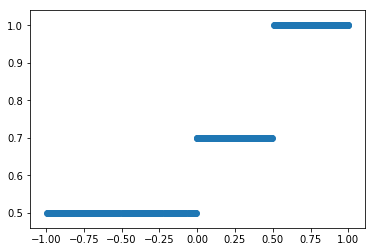

In [5]:
# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")

In [7]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()  # 先頭を表示

,x,Z,t,Y
0,-0.616961,1.0,0.5,2.303183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,0.0,1.0,2.245229
4,0.559952,0.0,1.0,2.139868


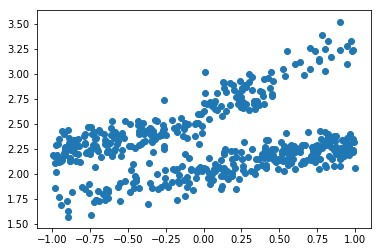

In [8]:
plt.scatter(x, Y)

### T-learner(Two)

In [9]:
# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

In [10]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 介入を受けていないモデル
reg_0 = RandomForestRegressor(max_depth=3)
reg_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
reg_1 = RandomForestRegressor(max_depth=3)
reg_1.fit(df_1[["x"]], df_1[["Y"]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestRegressor(max_depth=3)

In [11]:
# ATEを求める
mu_0 = reg_0.predict(df[["x"]])
mu_1 = reg_1.predict(df[["x"]])

ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)

ATE： 0.6703869421982507


In [12]:
# 処置群における平均処置効果ATTと、対照群における平均処置効果ATU
ATT = df_1["Y"] - reg_0.predict(df_1[["x"]])
ATU = reg_1.predict(df_0[["x"]]) - df_0["Y"]

print("ATT：", ATT.mean())
print("ATU：", ATU.mean())

ATT： 0.5884244766831148
ATU： 0.7470417076496993


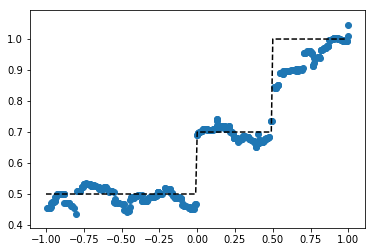

In [13]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg_1.predict(
    df[["x"]]) - reg_0.predict(df[["x"]])
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

### S-Learner(Single)

In [14]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# モデルを学習
reg = RandomForestRegressor(max_depth=4)
X = df.loc[:, ["x", "Z"]]
reg.fit(X, df[["Y"]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(max_depth=4)

In [15]:
# 処置が0と1の状態を作成する
X_0 = X.copy()
X_0["Z"] = 0.0

X_1 = X.copy()
X_1["Z"] = 1.0

# ATEの計算
ATE = (reg.predict(X_1)-reg.predict(X_0)).mean()
print("ATE：", ATE)

ATE： 0.6723197979076997


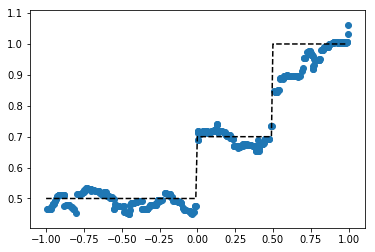

In [16]:
# 推定された治療効果を各人ごとに求めます
t_estimated = reg.predict(X_1)-reg.predict(X_0)
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

### X-Learner(傾向スコアを用いて、T-Leanerの結果を補正する手法）

In [17]:
# T-LearnerでM0とM1を求める
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M0 = RandomForestRegressor(max_depth=3)
M0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M1 = RandomForestRegressor(max_depth=3)
M1.fit(df_1[["x"]], df_1[["Y"]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=3)

In [18]:
# 推定された治療効果を各人ごとに求めます
tau_0 = reg_1.predict(df_0[["x"]]) - df_0["Y"]
tau_1 = df_1["Y"] - reg_0.predict(df_1[["x"]])

# ATTとATUを求めるモデルを作成します
M2 = RandomForestRegressor(max_depth=3)
M2.fit(df_0[["x"]], tau_0)

M3 = RandomForestRegressor(max_depth=3)
M3.fit(df_1[["x"]], tau_1)

RandomForestRegressor(max_depth=3)

In [19]:
# 傾向スコアを求めます
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)

# それぞれのモデルで全データの効果を予測し、傾向スコアで調整
tau = g_x_val[:, 1]*M2.predict(df[["x"]]) + g_x_val[:, 0]*M3.predict(df[["x"]])

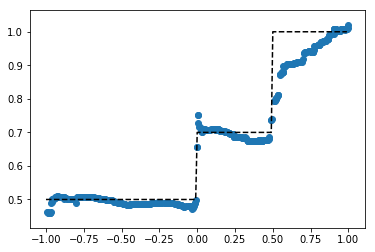

In [20]:
# 推定された治療効果を各人ごとに求めます
plt.scatter(df[["x"]], tau, label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')

### Doubly Robust Learning(?)

In [22]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [23]:
# 使用するパッケージ（ライブラリと関数）を定義
# 標準正規分布の生成用
from numpy.random import *

# グラフの描画用
import matplotlib.pyplot as plt

# SciPy 平均0、分散1に正規化（標準化）関数
import scipy.stats

# シグモイド関数をimport
from scipy.special import expit

# その他
import pandas as pd


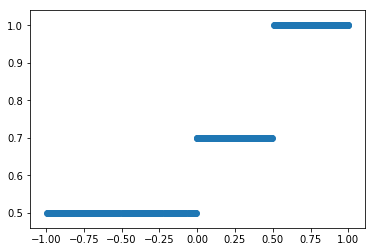

In [24]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")


In [25]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()  # 先頭を表示


,x,Z,t,Y
0,-0.616961,1.0,0.5,2.303183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,0.0,1.0,2.245229
4,0.559952,0.0,1.0,2.139868


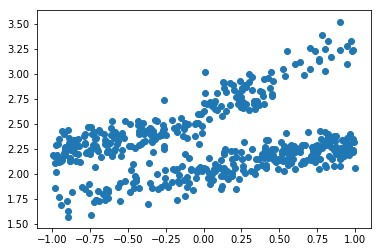

In [26]:
plt.scatter(x, Y)

DR-Learnerの開始、まずはT-Learner

In [27]:
# ランダムフォレストモデルを作成
from sklearn.ensemble import RandomForestRegressor

# 集団を2つに分ける
df_0 = df[df.Z == 0.0]  # 介入を受けていない集団
df_1 = df[df.Z == 1.0]  # 介入を受けた集団

# 介入を受けていないモデル
M_0 = RandomForestRegressor(max_depth=3)
M_0.fit(df_0[["x"]], df_0[["Y"]])

# 介入を受けたモデル
M_1 = RandomForestRegressor(max_depth=3)
M_1.fit(df_1[["x"]], df_1[["Y"]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=3)

In [28]:
# 傾向スコアを求めます
from sklearn.linear_model import LogisticRegression

# 説明変数
X = df[["x"]]

# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
g_x = LogisticRegression().fit(X, Z)
g_x_val = g_x.predict_proba(X)


DRに基づく推定

In [30]:
# 処置群
Y_1 = M_1.predict(df_1[["x"]]) + (df_1["Y"] - M_1.predict(df_1[["x"]])) / \
    g_x.predict_proba(df_1[["x"]])[:, 1]  # [:,1]はZ=1側の確率
df_1["ITE"] = Y_1 - M_0.predict(df_1[["x"]])

# 非処置群
Y_0 = M_0.predict(df_0[["x"]]) + (df_0["Y"] - M_0.predict(df_0[["x"]])) / \
    g_x.predict_proba(df_0[["x"]])[:, 0]  # [:,0]はZ=0側の確率
df_0["ITE"] = M_1.predict(df_0[["x"]]) - Y_0

# 表を結合する
df_DR = pd.concat([df_0, df_1])
df_DR.head()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,x,Z,t,Y,ITE
2,-0.124545,0.0,0.5,2.193123,-0.001272
3,0.570717,0.0,1.0,2.245229,0.827965
4,0.559952,0.0,1.0,2.139868,0.962872
5,-0.454815,0.0,0.5,1.973293,0.218243
6,-0.447071,0.0,0.5,1.953387,0.292839


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


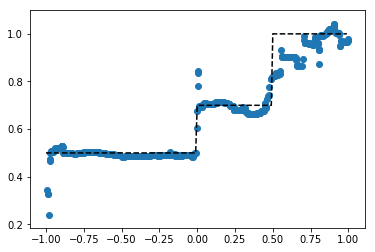

In [31]:
# モデルM_DRを構築し、各人の治療効果をモデルから求める

# モデルM_DR
M_DR = RandomForestRegressor(max_depth=3)
M_DR.fit(df_DR[["x"]], df_DR[["ITE"]])


# 推定された治療効果を各人ごとに求めます
t_estimated = M_DR.predict(df_DR[["x"]])
plt.scatter(df_DR[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')
